In [22]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
import pickle
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow_addons.optimizers import AdamW
import numpy as np
import matplotlib.pyplot as plt
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
with open('/datasets/almex_insurance/combined13_gt.pkl', 'rb') as f:
    raw_labels = pickle.load(f)
raw_labels[4000]
with open('/datasets/img/synth_gt.pkl', 'rb') as f:
    synth_labels = pickle.load(f)



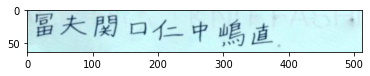

(64, 512, 3)
[756. 327. 132.  52. 547. 325. 586. 510.  -1.  -1.  -1.  -1.  -1.  -1.]


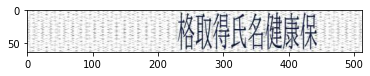

(64, 512, 3)
[266. 209. 254. 244. 119.  96. 108.  72.  -1.  -1.  -1.  -1.  -1.  -1.]


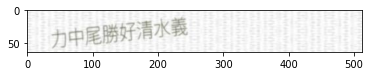

(64, 512, 3)
[663. 325. 384. 344. 517. 343. 386. 338.  -1.  -1.  -1.  -1.  -1.  -1.]


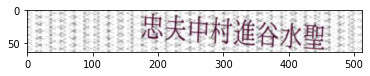

(64, 512, 3)
[ 3.890e+02  3.270e+02  3.250e+02  2.700e+01  1.270e+02  3.340e+02
  3.860e+02  1.337e+03 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00]


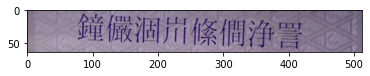

(64, 512, 3)
[ 1.555e+03  3.715e+03  3.764e+03  7.513e+03  5.226e+03  5.160e+03
  1.533e+03  4.548e+03 -1.000e+00 -1.000e+00 -1.000e+00 -1.000e+00
 -1.000e+00 -1.000e+00]


In [23]:
for i in range(5):
    synth_labels[0]
    im = plt.imread(synth_labels[i][0])
    plt.imshow(im)
    plt.show()
    print(im.shape)
    print(synth_labels[i][1])

# Data Pipeline

In [24]:
with open('/datasets/almex_insurance/combined13_gt.pkl', 'rb') as f:
    raw_labels = pickle.load(f)

# combined13_gt.pkl does not have full paths
for idx in range(len(raw_labels)):
    raw_labels[idx][0] = "/datasets/almex_insurance/combined/" + raw_labels[idx][0]
    
with open('/datasets/img/synth_gt.pkl', 'rb') as f:
    synth_labels = pickle.load(f)

# shuffle and split
np.random.shuffle(raw_labels)
np.random.shuffle(synth_labels)

n_val_raw = int(len(raw_labels)*0.1)
raw_labels_val = raw_labels[:n_val_raw]
raw_labels_train = raw_labels[n_val_raw:]

n_val_synth = int(len(synth_labels)*0.1)
synth_labels_val = synth_labels[:n_val_synth]
synth_labels_train = synth_labels[n_val_synth:]

labels_val = raw_labels_val + synth_labels_val
labels_train = raw_labels_train + synth_labels_train

np.random.shuffle(labels_train)
np.random.shuffle(labels_val)

# pad targets for batching
def pad(labels):
    for idx, lb in enumerate(labels):
        padded = np.zeros((14,)) - 1
        padded[:len(labels[idx][1])] = np.array(labels[idx][1])
        labels[idx][1] = padded
    return labels

labels_val = pad(labels_val)
labels_train = pad(labels_train)

# split x and y
x_val = [x[0] for x in labels_val]
y_val = np.array([x[1] for x in labels_val])
x_train = [x[0] for x in labels_train]
y_train = np.array([x[1] for x in labels_train])

print(len(x_train))
print(len(x_val))

2318123
257568


In [25]:
labels_val[0][0]

'/datasets/img/company_addr/152109.jpg'

In [9]:
p = tf.strings.regex_replace(labels_val[0][0], '/combined/', '/combined_blur7/')
p

<tf.Tensor: shape=(), dtype=string, numpy=b'/datasets/img/num/28163.jpg'>

14
/datasets/img/num/113035.jpg
[50. 31.  6. 49.  6.  1.  6. 39. -1. -1. -1. -1. -1. -1.]


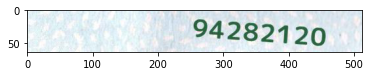

In [119]:
idx = 25
base = labels_val[idx]
print(len(base[1]))
print(base[0])
print(base[1])
img = plt.imread(base[0])
plt.imshow(img)

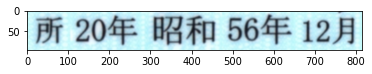

In [38]:
x_train[:]
# /datasets/almex_insurance/combined/3949.jpg
plt.imshow(plt.imread('/datasets/almex_insurance/combined_blur7/3949.jpg'))

In [26]:
HEIGHT = 64.

@tf.function
def parse_train(p, lb):
    aug_dice = tf.random.uniform(())
    if aug_dice < 0.2:
        p = tf.strings.regex_replace(p, '/combined/', '/combined_blur7/')
    elif aug_dice < 0.4:
        p = tf.strings.regex_replace(p, '/combined/', '/combined_blur5/')
    elif aug_dice < 0.6:
        p = tf.strings.regex_replace(p, '/combined/', '/combined_elastic/')
    elif aug_dice < 0.8:
        p = tf.strings.regex_replace(p, '/combined/', '/combined_b53d2/')
    img = tf.io.decode_jpeg(tf.io.read_file(p))
    img_shape = tf.cast(tf.shape(img), tf.float32)
    if tf.strings.regex_full_match(p, '.+combine.+'):
        crop_max = 0.15
    else:
        crop_max = 0.1
    crop_ratio = tf.random.uniform(()) * crop_max
    crop_h = img_shape[0] / (1 + crop_ratio)
    crop_w = tf.cast(img_shape[1], tf.int32) - tf.cast(crop_h * crop_ratio, tf.int32)
    crop_h = tf.cast(crop_h, tf.int32)
    img = tf.image.random_crop(img, (crop_h, crop_w, 3))
    img_shape = tf.cast(tf.shape(img), tf.float32)
    w = tf.cast(HEIGHT / img_shape[0] * img_shape[1], tf.int64)
    img = tf.image.resize(img, (int(HEIGHT), w), method=tf.image.ResizeMethod.AREA)
    lb = tf.cast(lb, tf.int64)
    lb_len = tf.reduce_sum(tf.cast(tf.not_equal(lb, -1), tf.int64))
    input_len = w // int(HEIGHT / 4)
    return img, lb, lb_len, input_len

@tf.function
def parse_val(p, lb):
    img = tf.io.decode_jpeg(tf.io.read_file(p))
    img_shape = tf.cast(tf.shape(img), tf.float32)
    if tf.strings.regex_full_match(p, '.+combine.+'):
        crop_max = 0.075
        crop_ratio = tf.random.uniform(()) * crop_max
        crop_h = img_shape[0] / (1 + crop_ratio)
        crop_w = tf.cast(img_shape[1], tf.int32) - tf.cast(crop_h * crop_ratio, tf.int32)
        crop_h = tf.cast(crop_h, tf.int32)
        img = tf.image.random_crop(img, (crop_h, crop_w, 3))
        img_shape = tf.cast(tf.shape(img), tf.float32)
    w = tf.cast(HEIGHT / img_shape[0] * img_shape[1], tf.int64)
    img = tf.image.resize(img, (int(HEIGHT), w), method=tf.image.ResizeMethod.AREA)
    lb = tf.cast(lb, tf.int64)
    lb_len = tf.reduce_sum(tf.cast(tf.not_equal(lb, -1), tf.int64))
    input_len = w // int(HEIGHT / 4)
    return img, lb, lb_len, input_len

@tf.function
def augment(img, lb, lb_len, input_len, delta=0.15):
    img = tf.cast(img, tf.uint8)
    img = tf.image.random_jpeg_quality(img, min_jpeg_quality=50, max_jpeg_quality=95)
    img = tf.image.random_contrast(img, 1 - delta, 1 + delta)
    img = tf.image.random_hue(img, delta)
    img = tf.image.random_saturation(img, 1 - delta, 1 + delta)
    img = tf.cast(img, tf.float32)
    
    if SP_NOISE:
        if tf.random.uniform(()) > 0.5:
            dice = tf.random.uniform(tf.shape(img)[:-1])
            dice = tf.expand_dims(dice, axis=-1)
            dice = tf.concat([dice]*3, axis=-1)
            white = tf.fill(tf.shape(img), tf.random.uniform(shape=[], minval=128., maxval=255.))
            black = tf.fill(tf.shape(img), tf.random.uniform(shape=[], minval=0., maxval=128.))
            img = tf.where(tf.less(dice, 0.01), white, img)
            img = tf.where(tf.greater(dice, 1-0.01), black, img)
    return img, lb, lb_len, input_len

@tf.function
def norm(img, lb, lb_len, input_len):
    img = tf.cast(img, tf.float32)
    return {'image': img, 'labels': lb, 'label_lengths': lb_len, 'input_lengths': input_len}

In [27]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 512
# BUF_SIZE =  int(10712 / (BATCH_SIZE / 256))
BUF_SIZE = len(x_train)
SP_NOISE = True

ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUF_SIZE).map(parse_train, num_parallel_calls=AUTO)
ds_train = ds_train.map(augment, num_parallel_calls=AUTO)
ds_train = ds_train.padded_batch(BATCH_SIZE).map(norm, num_parallel_calls=AUTO).prefetch(AUTO)

ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(parse_val, num_parallel_calls=AUTO)
ds_val = ds_val.padded_batch(BATCH_SIZE).map(norm, num_parallel_calls=AUTO).prefetch(AUTO)

In [28]:
for data_train in ds_train:
    test_data = data_train
#     print(data_train['image'])
#     print(data_train['labels'])
#     print(data_train['label_lengths'])
#     print(data_train['input_lengths'])
    break
    
# for data_val in ds_val:
#     break
    

In [39]:
test_data['image'].numpy()[1].shape

(64, 559, 3)

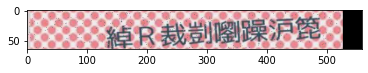

In [42]:
plt.imshow(test_data['image'].numpy()[500].astype(np.int))

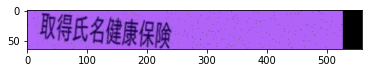

(64, 559, 3)
tf.Tensor([209 254 244 119  96 108  72 251  -1  -1  -1  -1  -1  -1], shape=(14,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(32, shape=(), dtype=int64)


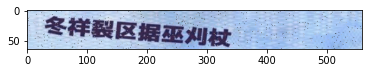

(64, 559, 3)
tf.Tensor([1029  891 2393   21 2345 3815 1472 2001   -1   -1   -1   -1   -1   -1], shape=(14,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(34, shape=(), dtype=int64)


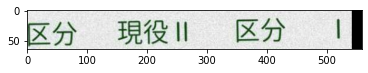

(64, 559, 3)
tf.Tensor([  21  168 1036 1056 7543   21  168 7542   -1   -1   -1   -1   -1   -1], shape=(14,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(33, shape=(), dtype=int64)


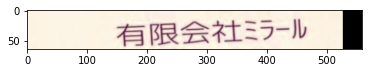

(64, 559, 3)
tf.Tensor([ 26  29   3   4 125 100  35  61  -1  -1  -1  -1  -1  -1], shape=(14,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(32, shape=(), dtype=int64)


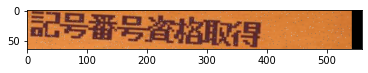

(64, 559, 3)
tf.Tensor([234  14   2  14 160 266 209 254  -1  -1  -1  -1  -1  -1], shape=(14,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(33, shape=(), dtype=int64)


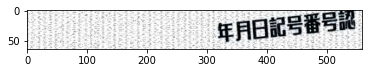

(64, 559, 3)
tf.Tensor([197 177  89 234  14   2  14 292  -1  -1  -1  -1  -1  -1], shape=(14,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(34, shape=(), dtype=int64)


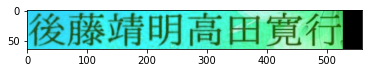

(64, 559, 3)
tf.Tensor([380 324 698 337  40   0 630  86  -1  -1  -1  -1  -1  -1], shape=(14,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(32, shape=(), dtype=int64)


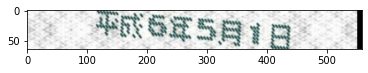

(64, 559, 3)
tf.Tensor([ 57 115  42 197  34 177   1  89  -1  -1  -1  -1  -1  -1], shape=(14,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(34, shape=(), dtype=int64)


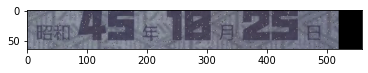

(64, 559, 3)
tf.Tensor([ 60  43  31  34 197   1  39 177   6  34  89  -1  -1  -1], shape=(14,), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)
tf.Tensor(32, shape=(), dtype=int64)


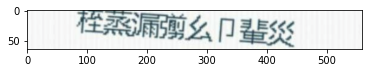

(64, 559, 3)
tf.Tensor([4288 2215 2330 3174 6331 5929 1302 1687   -1   -1   -1   -1   -1   -1], shape=(14,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(34, shape=(), dtype=int64)


In [53]:
# test_data['image'].numpy()[0,:,:,:]

num=2
for num in range(10):
    plt.imshow(np.array(test_data['image'].numpy()[num],np.int))
    plt.show()
    print(test_data['image'].numpy()[num].shape)
    print(test_data['labels'][num])
    print(test_data['label_lengths'][num])
    print(test_data['input_lengths'][num])

In [ ]:
## import matplotlib.pyplot as plt
with open("./id2char_std.pkl", "rb") as f:
    id2char = pickle.load(f)
    
idx = 0

# fig, ax = plt.subplots(2, 1, figsize=(10, 2))
# ax[0].imshow(keras.preprocessing.image.array_to_img(data_train["image"][idx]))
# ax[1].imshow(keras.preprocessing.image.array_to_img(data_val["image"][idx]))
# print("".join([id2char[int(x)] for x in data_train["labels"][idx] if x >=-0]))
# print("".join([id2char[int(x)] for x in data_val["labels"][idx] if x >=-0]))

# Model

In [14]:
class CTCLayer(keras.layers.Layer):
    
    def call(self, labels, logits, input_length, label_length):
        input_length = tf.cast(input_length, tf.int32)
        label_length = tf.cast(label_length, tf.int32)
        loss = keras.backend.ctc_batch_cost(
            labels, tf.nn.softmax(logits, axis=-1), input_length[:, tf.newaxis], label_length[:, tf.newaxis]
        )
        self.add_loss(tf.reduce_mean(loss))
    
#         decoded, neg_sum_logits = tf.nn.ctc_greedy_decoder(tf.transpose(logits, [1, 0, 2]), sequence_length=input_length)
#         label_sparse = keras.backend.ctc_label_dense_to_sparse(labels, label_length)
#         edit_distance = tf.edit_distance(decoded[0], label_sparse)
#         self.add_metric(tf.reduce_mean(edit_distance), name='edit_distance', aggregation='mean')
        return logits

In [20]:
config = {
    "alpha": 1.0,
    "minimalistic": True,
#     "weights": "imagenet",
    "weights": None,
    "include_top": False
}
image = keras.Input(shape=(None, None, 3), name="image")
labels = keras.Input(shape=(None,), dtype=tf.int64, name='labels')
label_lengths = keras.Input(shape=(), dtype=tf.int64, name='label_lengths')
input_lengths = keras.Input(shape=(), dtype=tf.int64, name='input_lengths')
base = keras.applications.MobileNetV3Large(input_tensor=image, **config)
if HEIGHT == 64:
    feature = base.get_layer("expanded_conv_11/Add").output
if HEIGHT == 32:
    feature = base.get_layer("expanded_conv_5/Add").output
logits = keras.layers.SeparableConv2D(7550, kernel_size=(4, 1),
                                     strides=1, padding="valid",
                                     depthwise_initializer="he_normal")(feature)
logits = keras.layers.Lambda(lambda x: tf.squeeze(x, 1), name='logits')(logits)
logits = CTCLayer()(labels, logits, input_lengths, label_lengths)
model = keras.Model(inputs=[base.input, labels, input_lengths, label_lengths], outputs=logits)
opt = AdamW(weight_decay=1e-4, learning_rate=1e-3)
model.compile(optimizer=tf.train.experimental.enable_mixed_precision_graph_rewrite(opt))

NameError: name 'HEIGHT' is not defined

In [61]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 200, 3)] 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 64, 200, 3)   0           image[0][0]                      
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 32, 100, 16)  432         rescaling_3[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 32, 100, 16)  64          Conv[0][0]                       
____________________________________________________________________________________________

# Train

In [325]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
SAVE_FOLDER = f"./ckpt/mobilev3L-{HEIGHT}-{timestamp}/"
MODEL_NAME = f"mobilev3L-{HEIGHT}"
early_stop = keras.callbacks.EarlyStopping(patience=5, verbose=1, min_delta=0.0001)
lr_adj = keras.callbacks.ReduceLROnPlateau(monitor='val_edit_distance', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
save = keras.callbacks.ModelCheckpoint(SAVE_FOLDER + MODEL_NAME + '-{epoch:02d}.ckpt', save_best_only=True, verbose=1, monitor='val_edit_distance', save_weights_only=True)

In [ ]:
history = model.fit(ds_train, 
                    epochs=2,
                    validation_data=ds_val,
                    callbacks=[early_stop, save, lr_adj])

In [34]:
model.load_weights('/workspace/dense.release/ckpt/mobilev3L-64.0-myna/mobilev3L-64.0-17.ckpt')

(64, 512, 3)
(64, 512, 3)


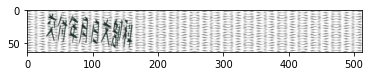

In [35]:
img = plt.imread(labels_val[0][0])
img_shape = img.shape
print(img_shape)
w = tf.cast(HEIGHT / img_shape[0] * img_shape[1], tf.int64)
img = tf.image.resize(img, (int(HEIGHT), w), method=tf.image.ResizeMethod.AREA)
plt.imshow(img.numpy().astype(np.int))
print(img.shape)

In [ ]:
# model.predict(img)

In [51]:
prob = tf.keras.layers.Softmax(name='prob')(model.get_layer('separable_conv2d').output)
# prob = model.get_layer('separable_conv2d').output

In [52]:
new_model = tf.keras.Model(inputs=model.get_layer('image').input,outputs=prob)

In [ ]:
new_model.summary()

In [54]:
# pred = new_model.predict(img[np.newaxis,::])
# print(pred)
# np.squeeze(pred,axis=0).shape

In [55]:
with open("./id2char_std.pkl", "rb") as f:
    id2char = pickle.load(f)
len(id2char)


7549

(115, 484, 3)
(64, 200, 3)
[[[[3.21260632e-05 1.88183761e-03 3.95171855e-06 ... 2.04283006e-05
    1.17731843e-05 1.96826812e-02]
   [5.73068450e-04 1.22879073e-01 9.52336268e-06 ... 2.85419701e-05
    1.13648355e-04 2.51699775e-01]
   [2.28461833e-03 1.00572899e-01 4.97932888e-05 ... 2.29027173e-05
    2.98997861e-07 4.40239906e-02]
   ...
   [2.43053222e-09 2.98652845e-03 1.07954907e-06 ... 2.28432455e-08
    2.24884006e-05 1.48426197e-05]
   [1.31418574e-07 1.04787914e-05 1.91136792e-06 ... 1.51559095e-06
    1.93760625e-05 1.52781522e-05]
   [2.33441426e-07 1.88517170e-05 1.15779483e-06 ... 7.63391824e-07
    3.04256355e-05 9.94371653e-01]]]]
(1, 1, 12, 7550)
12
([<tf.Tensor: shape=(1, 12), dtype=int64, numpy=
array([[ 211,   39,    1,   42, 1437,    6,   31,   42,   -1,   -1,   -1,
          -1]])>], <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9.909819]], dtype=float32)>)
ヒ０１６ｈ２４６


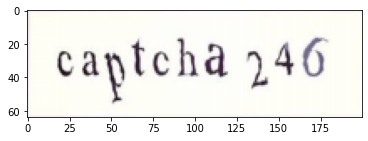

In [73]:
# workspace/dense.release/photo_2021-10-19_12-25-52.jpg
img = plt.imread('./photo_2021-10-19_12-25-52.jpg')
img_shape = img.shape
print(img_shape)
w = tf.cast(HEIGHT / img_shape[0] * img_shape[1], tf.int64)
img = tf.image.resize(img, (int(HEIGHT), 200), method=tf.image.ResizeMethod.AREA)
plt.imshow(img.numpy().astype(np.int))
print(img.shape)


pred = new_model.predict(img[np.newaxis,::])
print(pred)
print(pred.shape)
input_len = img.shape[1] // 16
print(input_len)
pred = np.squeeze(pred,axis=1)
# print(pred.shape)
# decoded = keras.backend.ctc_decode(pred, input_length=[input_len])
decoded = keras.backend.ctc_decode(pred, input_length=[12])
print(decoded)
text = "".join([id2char[x] for x in decoded[0][0].numpy()[0] if x != -1])
print(text)

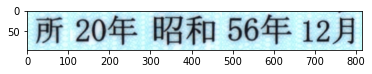

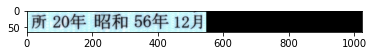

In [62]:
import cv2

def resize_pad(img, h, w):
    w_new = int(h / img.shape[0] * img.shape[1])
    img = cv2.resize(img, (w_new, h), cv2.INTER_AREA)
    if img.shape[1] >= w: return img[:, :w], w // 16
    padded = np.zeros((h, w, 3)).astype(img.dtype)
    padded[:, :img.shape[1]] = img
    return padded, img.shape[1] // 16

plt.imshow(plt.imread("./data/1.jpg"))
plt.show()
img, input_len = resize_pad(plt.imread("./data/1.jpg"), 64, 1024)
plt.imshow(img)

In [ ]:
prob = new_model.predict(img[np.newaxis,::])
print(prob.shape)
prob = np.squeeze(prob,axis=1)
decoded = keras.backend.ctc_decode(prob, input_length=[input_len])
print(decoded)
text = "".join([id2char[x] for x in decoded[0][0].numpy()[0] if x != -1])
print(text)

In [296]:
max(prob[0][0])

0.9980185